# Minimal Q-Learning in a 5×5 GridWorld (4 actions)



In [45]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# Grid settings
N_ROWS, N_COLS = 25, 25
START = (0, 0)
GOAL  = (24, 24)
WALLS = [
    # Sparse walls ensuring 4-action path remains available
    # Top-left quadrant
    (2, 2), (3, 4), (5, 1), (7, 3), (4, 6), (8, 2), (6, 7),
    # Top-right quadrant  
    (2, 15), (4, 18), (6, 12), (8, 20), (3, 22), (7, 16), (9, 14),
    # Bottom-left quadrant
    (15, 2), (18, 5), (20, 1), (16, 7), (22, 4), (19, 8), (17, 3),
    # Bottom-right quadrant
    (15, 18), (17, 21), (19, 16), (21, 19), (18, 23), (16, 15), (20, 17),
    # Middle area - strategic placement
    (10, 10), (12, 8), (14, 12), (11, 15), (13, 6), (9, 18), (15, 9),
    # Additional scattered walls
    (5, 11), (8, 16), (11, 3), (14, 20), (17, 6), (20, 13), (23, 8),
    (1, 9), (4, 14), (7, 19), (10, 22), (13, 17), (16, 11), (19, 2),
    (22, 15), (6, 5), (9, 8), (12, 18), (15, 4), (18, 14), (21, 7),
    # Edge walls (not blocking main paths)
    (1, 23), (23, 1), (3, 0), (0, 3), (24, 21), (21, 24)
]
#WALLS = [(1,3), (2,2), (3,1)]  # diagonal obstacles

# Rewards
STEP_REWARD = -0.1
bump_reward = -0.1

GOAL_REWARD = 1.0
GAMMA = 0.95

# 4 actions: Up, Down, Left, Right (row, col deltas)
ACTIONS_4 = {
    0: (-1, 0),  # Up
    1: ( 1, 0),  # Down
    2: ( 0,-1),  # Left
    3: ( 0, 1),  # Right
}


All required functions:

In [46]:
def in_bounds(s):
    r, c = s
    return 0 <= r < N_ROWS and 0 <= c < N_COLS

def to_index(s):
    r, c = s
    return r * N_COLS + c

def from_index(i):
    r = i // N_COLS
    c = i % N_COLS
    return (r, c)

def step(s, a, actions):
    """Deterministic step using the given action map.
    Returns (next_state, reward, done)."""
    if s == GOAL:
        return s, 0.0, True
    dr, dc = actions[a]
    nr, nc = s[0] + dr, s[1] + dc
    ns = (nr, nc)
    if not in_bounds(ns) or ns in WALLS:
        ns = s  # stay put if invalid
    if ns == GOAL:
        return ns, GOAL_REWARD, True
    else:
        return ns, STEP_REWARD, False

def epsilon_greedy(q_row, epsilon, rng):
    if rng.random() < epsilon:
        return int(rng.integers(len(q_row)))
    # break ties randomly among maxima
    max_q = np.max(q_row)
    best = np.flatnonzero(q_row == max_q)
    return int(rng.choice(best))

def moving_average(x, w=20):
    if len(x) < w:
        return x.copy()
    return np.convolve(x, np.ones(w)/w, mode='valid')


More functions for visualisation:

In [47]:
ARROWS = {0: '↑', 1: '↓', 2: '←', 3: '→', 4: '↘'}

def derive_policy(Q):
    return np.argmax(Q, axis=1).reshape(N_ROWS, N_COLS)

def render_policy(policy):
    grid = []
    for r in range(N_ROWS):
        row = []
        for c in range(N_COLS):
            s = (r, c)
            if s in WALLS:
                row.append('■')
            elif s == GOAL:
                row.append('G')
            elif s == START:
                row.append('S')
            else:
                row.append(ARROWS[int(policy[r, c])])
        grid.append(' '.join(row))
    print('\nOptimal policy (arrows), S=start, G=goal, ■=wall')
    print('\n'.join(grid))

def print_value_grid(Q):
    V = np.max(Q, axis=1).reshape(N_ROWS, N_COLS)
    with np.printoptions(precision=2, suppress=True):
        print('\nState-value grid V(s)=max_a Q(s,a):')
        print(V)

## **1. Q learning with 4 actions:**

In [48]:
# Q-learning hyperparameters
EPISODES = 600
ALPHA = 0.5
EPS_START, EPS_END, EPS_DECAY_EPISODES = 1.0, 0.05, 300
MAX_STEPS = 200
SEED = 123

rng = np.random.default_rng(SEED)
random.seed(SEED)
np.random.seed(SEED)

NUM_STATES = N_ROWS * N_COLS
NUM_ACTIONS_4 = 4
Q4 = np.zeros((NUM_STATES, NUM_ACTIONS_4), dtype=float)

returns = np.zeros(EPISODES, dtype=float)
bumps = np.zeros(EPISODES, dtype=float)
steps_arr = np.zeros(EPISODES, dtype=int)

eps = EPS_START
eps_decay = (EPS_START - EPS_END) / max(1, EPS_DECAY_EPISODES)


for ep in range(EPISODES):
    s = START
    si = to_index(s)
    done = False
    G = 0.0
    bumpcount = 0
    disc = 1.0
    steps = 0

    for t in range(MAX_STEPS):
        a = epsilon_greedy(Q4[si], eps, rng)
        s_next, r, done = step(s, a, ACTIONS_4)
        s_next_i = to_index(s_next)

        if si==s_next_i:
          bumpcount+=1
          r = bump_reward

        target = r if done else r + GAMMA * np.max(Q4[s_next_i])
        Q4[si, a] += ALPHA * (target - Q4[si, a])

        G += disc * r
        disc *= GAMMA
        s, si = s_next, s_next_i
        steps += 1
        if done:
            break

    returns[ep] = G
    bumps[ep] = bumpcount
    steps_arr[ep] = steps
    if ep < EPS_DECAY_EPISODES:
        eps = max(EPS_END, eps - eps_decay)

print('Training (4 actions) complete!')
returns4=returns.copy()
bumps4=bumps.copy()
ma_w = 25
ret_ma4 = moving_average(returns4, w=ma_w)

Training (4 actions) complete!


In [49]:
policy4 = derive_policy(Q4)
render_policy(policy4)
print_value_grid(Q4)



Optimal policy (arrows), S=start, G=goal, ■=wall
S ↓ ↓ ■ ↑ → ↓ ↑ → → ↓ → ↑ ↓ → ↑ ← ↓ ↓ ← → → ↓ ↑ →
↑ ↓ → ↓ → → → ↓ ↑ ■ ↓ ↑ ↓ → ↑ ↓ ↓ ↑ ← ↓ → ↓ ↓ ■ ↓
→ → ■ → → → ← ↓ ↓ ↑ → ↑ → → → ■ ← → ↑ → ↓ ← ↑ ↑ →
■ ↑ ← ↑ ■ ← ← → → → → ↓ ↑ → ↑ → → ↓ → ↓ → ↓ ■ ↓ ↑
↑ ← → → ↑ → ■ ↓ → → → ↓ ↓ ← ■ ↓ ↑ → ■ ← → ↓ ← ↑ ↑
↑ ■ ← → ↓ → → ← → ↓ ↓ ■ ↓ → ↑ ← ← → → ↓ → ↓ ↓ ↓ ↓
↓ ↓ ← ↓ → ■ ↑ ■ ↓ ↑ → → ■ → ↓ ↓ ← ← → → → ↓ → ↓ ↓
← ↓ ↓ ■ → ↑ ↑ ↓ ↓ → → ↓ ← ← ← ↑ ■ ↓ ↓ ■ → ↓ ↓ → ↓
↓ ↓ ■ ↑ ↑ ↓ → ↓ ↓ → ↓ ↓ → ↑ ↑ ↓ ■ → → ↓ ■ ↓ ← ↓ ↓
↓ ↓ ← ↑ ↓ ↓ ↓ → ■ ↓ ↓ ↓ ↓ ↓ ■ → ↓ ↓ ■ → → ↓ ← ↓ ↓
→ → ↓ → ↓ → → ↓ → ↓ ■ ← ↑ ↓ ↓ → ↓ → → → → ↓ ■ ↓ ←
→ ↑ ← ■ → → ↓ → ↑ → → ↓ ↓ ↓ ↓ ■ ↓ → → ↓ → ↓ ↓ ← ↓
↓ ↓ ↓ ↓ ← → ↑ ↓ ■ ← ↓ ↓ → ↓ → ↓ ↓ ↑ ■ → → ↓ ↓ ↓ ↓
↓ ↓ ↓ ↓ → ↑ ■ ↓ ← ← → → → → → ↓ ↓ ■ ↓ → → → ↓ ← ←
← ↓ → ↓ ↑ → → ↓ ↓ → ↓ ↓ ■ ↓ ↓ → ↓ ↓ ← ↑ ■ ↓ ↓ ← →
← → ■ ↓ ■ ↓ ↓ → ↓ ■ → → → ↓ → → → ↓ ■ ↓ ↓ ↓ ↓ ← ↓
↓ ← ↑ ↑ ↑ ↑ ↓ ■ → ↓ ↓ ■ ↓ → ↓ ■ ↓ ↓ ↑ ↓ ↓ → ↓ ← ↓
→ ↑ ← ■ ↓ ↓ ■ ↑ → → → → → → → → → ↓ → ↓ ↓ ■ ↓ ← ↓
→ ↑ ← ↑ ↓ ■ ← ← → ↓ ← ↑ ↑ ↑ ■ → → → → → → → ↓ ■ ↓


## Add a 5th action: South‑East diagonal


In [50]:
# Extend the action set
ACTIONS_5 = dict(ACTIONS_4)
ACTIONS_5[4] = (1, 1)  # south-east (down-right)
#print('ACTIONS_5:', ACTIONS_5)

# Extend the Q-table from 4 actions -> 5 actions (initialization example)
#Q5 = np.zeros((NUM_STATES, 5), dtype=float)
#Q5[:, :4] = Q4  # keep learned values for the original 4 actions

# Optional: optimistic init for the new action using V_old(s)=max_a Q4(s,a)
#V_old = np.max(Q4, axis=1)
#Q5[:, 4] = V_old  # or 0.0 if you prefer neutral init

# Demo: take one south-east step from (0,0) using the new action map
s_demo = (3, 2)
s_next_demo, r_demo, done_demo = step(s_demo, 4, ACTIONS_5)
print('From', s_demo, 'SE ->', s_next_demo, '| reward=', r_demo, '| done=', done_demo)
render_policy(policy4)

From (3, 2) SE -> (4, 3) | reward= -0.1 | done= False

Optimal policy (arrows), S=start, G=goal, ■=wall
S ↓ ↓ ■ ↑ → ↓ ↑ → → ↓ → ↑ ↓ → ↑ ← ↓ ↓ ← → → ↓ ↑ →
↑ ↓ → ↓ → → → ↓ ↑ ■ ↓ ↑ ↓ → ↑ ↓ ↓ ↑ ← ↓ → ↓ ↓ ■ ↓
→ → ■ → → → ← ↓ ↓ ↑ → ↑ → → → ■ ← → ↑ → ↓ ← ↑ ↑ →
■ ↑ ← ↑ ■ ← ← → → → → ↓ ↑ → ↑ → → ↓ → ↓ → ↓ ■ ↓ ↑
↑ ← → → ↑ → ■ ↓ → → → ↓ ↓ ← ■ ↓ ↑ → ■ ← → ↓ ← ↑ ↑
↑ ■ ← → ↓ → → ← → ↓ ↓ ■ ↓ → ↑ ← ← → → ↓ → ↓ ↓ ↓ ↓
↓ ↓ ← ↓ → ■ ↑ ■ ↓ ↑ → → ■ → ↓ ↓ ← ← → → → ↓ → ↓ ↓
← ↓ ↓ ■ → ↑ ↑ ↓ ↓ → → ↓ ← ← ← ↑ ■ ↓ ↓ ■ → ↓ ↓ → ↓
↓ ↓ ■ ↑ ↑ ↓ → ↓ ↓ → ↓ ↓ → ↑ ↑ ↓ ■ → → ↓ ■ ↓ ← ↓ ↓
↓ ↓ ← ↑ ↓ ↓ ↓ → ■ ↓ ↓ ↓ ↓ ↓ ■ → ↓ ↓ ■ → → ↓ ← ↓ ↓
→ → ↓ → ↓ → → ↓ → ↓ ■ ← ↑ ↓ ↓ → ↓ → → → → ↓ ■ ↓ ←
→ ↑ ← ■ → → ↓ → ↑ → → ↓ ↓ ↓ ↓ ■ ↓ → → ↓ → ↓ ↓ ← ↓
↓ ↓ ↓ ↓ ← → ↑ ↓ ■ ← ↓ ↓ → ↓ → ↓ ↓ ↑ ■ → → ↓ ↓ ↓ ↓
↓ ↓ ↓ ↓ → ↑ ■ ↓ ← ← → → → → → ↓ ↓ ■ ↓ → → → ↓ ← ←
← ↓ → ↓ ↑ → → ↓ ↓ → ↓ ↓ ■ ↓ ↓ → ↓ ↓ ← ↑ ■ ↓ ↓ ← →
← → ■ ↓ ■ ↓ ↓ → ↓ ■ → → → ↓ → → → ↓ ■ ↓ ↓ ↓ ↓ ← ↓
↓ ← ↑ ↑ ↑ ↑ ↓ ■ → ↓ ↓ ■ ↓ → ↓ ■ ↓ ↓ ↑ ↓ ↓ → ↓ ← ↓
→ ↑ ← ■ ↓ ↓ ■ ↑ → → → → → → → → → ↓ → ↓ ↓ ■ ↓ 

## **2. Plain Q learning with 5 actions:**

In [51]:
# Q-learning for 5 actions
EPISODES = 600
ALPHA = 0.5
EPS_START, EPS_END, EPS_DECAY_EPISODES = 1.0, 0.05, 300
MAX_STEPS = 200
SEED = 123

rng = np.random.default_rng(SEED)
random.seed(SEED)
np.random.seed(SEED)

NUM_STATES = N_ROWS * N_COLS
NUM_ACTIONS_5 = 5
Q5 = np.zeros((NUM_STATES, NUM_ACTIONS_5), dtype=float)

returns = np.zeros(EPISODES, dtype=float)
bumps = np.zeros(EPISODES, dtype=float)
steps_arr = np.zeros(EPISODES, dtype=int)

eps = EPS_START
eps_decay = (EPS_START - EPS_END) / max(1, EPS_DECAY_EPISODES)


for ep in range(EPISODES):
    s = START
    si = to_index(s)
    done = False
    G = 0.0
    bumpcount = 0
    disc = 1.0
    steps = 0

    for t in range(MAX_STEPS):
        a = epsilon_greedy(Q5[si], eps, rng)
        s_next, r, done = step(s, a, ACTIONS_5)
        s_next_i = to_index(s_next)

        if si==s_next_i:
          bumpcount+=1
          r = bump_reward

        target = r if done else r + GAMMA * np.max(Q5[s_next_i])
        Q5[si, a] += ALPHA * (target - Q5[si, a])

        G += disc * r
        disc *= GAMMA
        s, si = s_next, s_next_i
        steps += 1
        if done:
            break

    returns[ep] = G
    bumps[ep] = bumpcount
    steps_arr[ep] = steps
    if ep < EPS_DECAY_EPISODES:
        eps = max(EPS_END, eps - eps_decay)

print('Training (5 actions) complete!')


policy5plain = derive_policy(Q5)
render_policy(policy5plain)
print_value_grid(Q5)
returns5plain=returns.copy()
Q5plain=Q5.copy()
bumps5plain=bumps.copy()

ma_w = 25
ret_ma5plain = moving_average(returns, w=ma_w)
steps_m5plain = moving_average(steps_arr.astype(float), w=ma_w)

Training (5 actions) complete!

Optimal policy (arrows), S=start, G=goal, ■=wall
S ↘ → ■ ↑ → ↘ ↑ ↓ ↘ → ↓ ↑ ↘ ↑ ↑ ← → ↑ ↑ → ↘ ↘ ↑ ←
↘ ↓ → → ↑ ↘ ↘ ↘ ↑ ■ → ↑ ↘ → ↑ → → ↘ → → ↑ ↑ ↓ ■ ←
↓ ← ■ → ↘ ↘ → ↘ ↑ ↑ ↑ ↑ → ↓ ↑ ■ ← → ← ↘ ↑ ↘ ↘ ↓ ↘
■ ↓ ← ↘ ■ → → ↑ ↘ → ↘ ↘ ↓ → → ↘ ↓ ↓ → ↑ ↘ ↑ ■ ← ↘
↘ ← ↓ ↘ ↘ ← ■ ↓ ↑ ↘ ↘ ↘ ↓ ← ■ ↘ ↓ ← ■ ↓ ↑ ← ↑ ↑ →
→ ■ ↓ ↓ → ↘ ↓ ↘ ↑ ↓ → ■ → ↘ → → ← → → ← ↑ ↑ → ↑ ↓
→ ← ↓ ← ↘ ■ → ■ → ↘ ↓ ↘ ■ ↘ ↑ ← → ↓ ↑ → ↓ → ← ↑ →
↓ ← ↘ ■ ↘ ↘ ↓ → ↘ ↘ → ↓ → → ↘ ↓ ■ → ← ■ → ↓ ← → ↑
↓ → ■ ↘ ↑ ↘ ↘ ↓ ↘ ↘ ↓ ↓ ↘ ↓ ↘ ↘ ■ ↓ → ↘ ■ ↓ ↘ ↘ ↘
↓ → ↘ ↑ ↘ ↘ ↘ ↘ ■ → ↘ ↘ ↓ ↓ ■ → ↘ → ■ ↘ ↘ ↓ → ↘ ↓
← ← ↓ ↓ ↑ ↘ ↘ ↘ ↑ ↘ ■ ↓ ↓ ↘ ↓ ← ↘ ↘ ↓ ↓ ↓ ↓ ■ ↓ ↓
← ↘ ↘ ■ → ↓ ↑ → ↘ ↘ → ↘ ↓ ↘ ↓ ■ ↘ ↘ ↘ ↓ ↓ ↘ ↓ ↓ ←
↘ → ↓ ↓ ← ← ↑ ↘ ■ ↘ → ↘ ↘ ↘ ↓ ↘ ↓ ↘ ■ ↘ ↓ ↘ ↓ ↓ ↘
← ← ↑ ← ← ↑ ■ ↘ → → ↘ ↓ ↘ ↘ ↓ → ↓ ■ ↘ → ↘ ↘ ↓ ← ←
← ↑ → → ↑ ↘ → ← → → → ↘ ■ ↓ ↘ ↓ ↘ ↓ ↘ ↘ ■ ↘ ↓ ← ↓
↓ ↓ ■ ↑ ■ → ↓ → ↘ ■ → → → ↘ ↓ ↘ ↓ ↘ ■ ↓ ↘ ↘ ↓ ← ←
↑ ↓ ↓ ← ↑ ← ← ■ ↓ ↘ ↘ ■ ↘ ↘ ↘ ■ ↘ ↘ ↘ ↘ ↓ ↘ ↓ ← ←
↘ → ← ■ → ← ■ → ↘ ↘ → → → → ↘ ↘ ↘ ↘ ↓ ↓ ↘ ■ ↓ ← ↓
↑ → ↓ ↑ ↘ ■ ↑ → ↑ ↘

## **3. Q learning with 5 actions and an oracle model**

In [52]:
def oracle_model(s):
  s_model_next, r_model, done_model = step(from_index(s), 4, ACTIONS_5)
  return s_model_next

Training (5 actions) complete!

Optimal policy (arrows), S=start, G=goal, ■=wall
S ↓ ↘ ■ ↘ → → → → → ↓ → ↑ ↓ → ↑ ← ↓ ↓ ← → → ↓ ↑ →
↘ ↓ ↘ ↘ ↘ ↘ ↘ ↘ ↘ ■ ↓ ↑ ↑ → ↑ ↓ ↓ ↑ ← ↓ → ↓ ↓ ■ ↓
↘ ↓ ■ ↓ → ↘ ↘ ↘ ↑ ↘ → ↘ → → → ■ ← → ↑ → ↓ ← ↑ ↑ →
■ ↘ ↓ ↓ ■ → ↘ ↘ ↓ ↘ ↘ → ↘ → ↑ → → ↓ → ↓ → ↓ ■ ↓ ↑
↓ → ↘ ↓ ← ↘ ■ ↘ ↓ ↘ ↘ ↘ ↘ ↘ ■ ↓ ↑ → ■ ← → ↓ ↓ ↑ ↓
↘ ■ → ↘ ↓ ↘ → ↘ ↘ ↘ ↘ ■ ↘ ↘ ↑ ↘ ↘ ↘ ↘ ↓ ↘ ↓ ↓ ↓ ↘
↘ ↘ ↑ → ↘ ■ ↓ ■ ↘ ↘ ↓ ↘ ■ ↘ ↘ → ↘ ↓ → → → ↓ → ↘ ↓
↘ ↓ ↘ ■ ↘ ↘ ↓ → ↘ ↘ ↘ ↘ ↘ ↘ ↘ ↓ ■ ↘ ↘ ■ → ↓ ↓ ↓ ↓
↘ ↘ ■ ↘ ↑ ↘ ↘ ↓ ↘ ↘ ↓ ↘ ↓ ↓ ↘ ↘ ■ → ↘ ↘ ■ ↓ ↘ ↓ ↓
↘ ↓ ↘ ← → → → ↘ ■ → ↘ ↓ ↓ ↓ ■ ↘ ↘ ↘ ■ ↓ → ↓ ← ↓ ↓
↘ ↘ ↑ ↘ ↘ ↘ ↘ ↘ ↘ ↘ ■ ↘ ↓ ↘ ↓ ↘ ↓ → ↘ ↓ → ↘ ■ ↓ ←
↓ ↘ ↘ ■ ↓ → → → ↘ ↘ ↘ ↘ ↘ ↓ ↘ ■ ↘ ↓ → ↘ → ↘ ↓ ← ←
↓ ↘ ↘ ↓ ↘ → ↘ ↘ ■ → ↘ ↘ → ↘ ↓ ↘ ↓ ↘ ■ ↘ ↘ ↘ ↓ ↓ ←
↓ ↘ ↓ ↑ → ↘ ■ ↘ ↘ ↘ → → ↘ → ↘ ↓ ↓ ■ ↓ → → ↘ ↓ ← ←
← ↑ → ↑ ↘ → ↘ ↘ → → ↘ ↘ ■ ↘ ↘ ↘ ↘ ↓ ↘ ↘ ■ ↓ ↓ ↘ ←
↘ ↘ ■ ↓ ■ ↘ → ↘ ↘ ■ → → → ↘ ↓ ↘ ↘ ↓ ■ ↘ ↘ ↘ ↓ ↘ ↓
↓ ← ↑ ↑ ↘ ↓ ↘ ■ ↘ → ↘ ■ ↘ → ↘ ■ ↘ ↘ ↓ ↘ → ↘ ↓ ← ↓
↘ → ↘ ■ ↓ ↘ ■ ↘ → → → ↘ ↘ → ↘ ↘ ↘ ↓ ↘ ↓ ↓ ■ ↓ ↘ ↓
→ ↓ ↘ → ↘ ■ ↘ → ↘ ↓

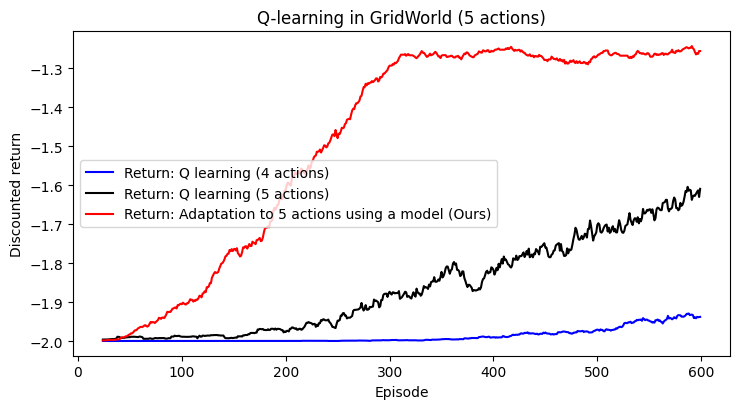

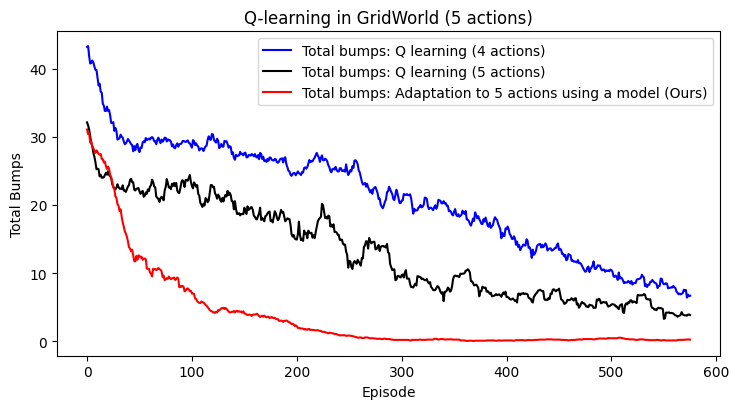

In [53]:
# Extend the Q-table from 4 actions -> 5 actions (initialization example)
Q5 = np.zeros((NUM_STATES, 5), dtype=float)
Q5[:, :4] = Q4  # keep learned values for the original 4 actions
V_old = np.max(Q4, axis=1)
Q5[:, 4] = V_old  # initialise Q values for new actions optimistically

# Q-learning for 5 actions
EPISODES = 600
ALPHA = 0.5
EPS_START, EPS_END, EPS_DECAY_EPISODES = 1.0, 0.05, 300
MAX_STEPS = 200
SEED = 123

rng = np.random.default_rng(SEED)
random.seed(SEED)
np.random.seed(SEED)

NUM_STATES = N_ROWS * N_COLS
NUM_ACTIONS_5 = 5


returns = np.zeros(EPISODES, dtype=float)
bumps = np.zeros(EPISODES, dtype=float)
steps_arr = np.zeros(EPISODES, dtype=int)

eps = EPS_START
eps_decay = (EPS_START - EPS_END) / max(1, EPS_DECAY_EPISODES)


for ep in range(EPISODES):
    s = START
    si = to_index(s)
    done = False
    G = 0.0
    bumpcount = 0
    disc = 1.0
    steps = 0

    for t in range(MAX_STEPS):
        a = epsilon_greedy(Q5[si], eps, rng)
        if a==4: #check whether new action is selected
          snext_model=oracle_model(si) #deploy the model
          if max(Q5[to_index(snext_model)])<max(Q5[si]):#only accept the action if the transition leads to a state of higher Q value
            a = epsilon_greedy(Q4[si], eps, rng)#otherwise do action selection as per original actions only

        s_next, r, done = step(s, a, ACTIONS_5)
        s_next_i = to_index(s_next)

        if si==s_next_i:
          bumpcount+=1
          #r=-0.5

        target = r if done else r + GAMMA * np.max(Q5[s_next_i])
        Q5[si, a] += ALPHA * (target - Q5[si, a])

        G += disc * r
        disc *= GAMMA
        s, si = s_next, s_next_i
        steps += 1
        if done:
            break

    returns[ep] = G
    bumps[ep] = bumpcount
    steps_arr[ep] = steps
    if ep < EPS_DECAY_EPISODES:
        eps = max(EPS_END, eps - eps_decay)

print('Training (5 actions) complete!')



policy5 = derive_policy(Q5)
render_policy(policy5)
#render_policy(policy5plain)
print_value_grid(Q5)
returns5=returns.copy()
bumps5=bumps.copy()

ma_w = 25
ret_ma5 = moving_average(returns, w=ma_w)
steps_m5 = moving_average(steps_arr.astype(float), w=ma_w)

bumps4_avg = moving_average(bumps4, w=ma_w)
bumps5plain_avg = moving_average(bumps5plain, w=ma_w)
bumps5_avg = moving_average(bumps5, w=ma_w)

plt.figure(figsize=(7.5, 4.2))
plt.plot(np.arange(len(returns4))[-len(ret_ma4):], ret_ma4, 'b', label='Return: Q learning (4 actions)')
plt.plot(np.arange(len(returns5plain))[-len(ret_ma5plain):], ret_ma5plain, 'k', label='Return: Q learning (5 actions)')
plt.plot(np.arange(len(returns5))[-len(ret_ma5):], ret_ma5, 'r', label='Return: Adaptation to 5 actions using a model (Ours)')
plt.xlabel('Episode')
plt.ylabel('Discounted return')
plt.title('Q-learning in GridWorld (5 actions)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7.5, 4.2))
plt.plot(bumps4_avg, 'b', label='Total bumps: Q learning (4 actions)')
plt.plot(bumps5plain_avg, 'k', label='Total bumps: Q learning (5 actions)')
plt.plot(bumps5_avg, 'r', label='Total bumps: Adaptation to 5 actions using a model (Ours)')
plt.xlabel('Episode')
plt.ylabel('Total Bumps')
plt.title('Q-learning in GridWorld (5 actions)')
plt.legend()
plt.tight_layout()
plt.show()

**2 things to note here: Our method learns faster and better policies than the 4 action case (which is expected) and we encounter fewer unsafe actions both compared to regular Q learning with 5 actions, as well as compared to the original Q learning with 4 actions.**